In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version 1.12.1
PyG version 2.1.0
e3nn version 0.4.4
Using device: cpu


In [3]:
def create_kchains(k):
    assert k >= 2
    
    dataset = []

    # Graph 0
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[-4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Graph 1
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

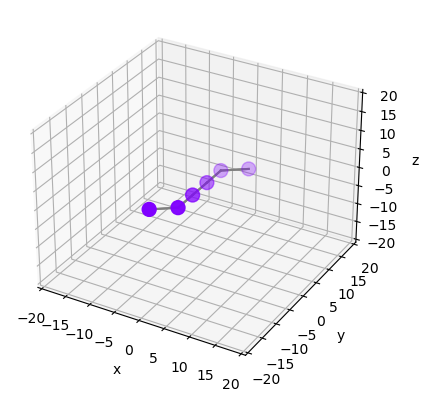

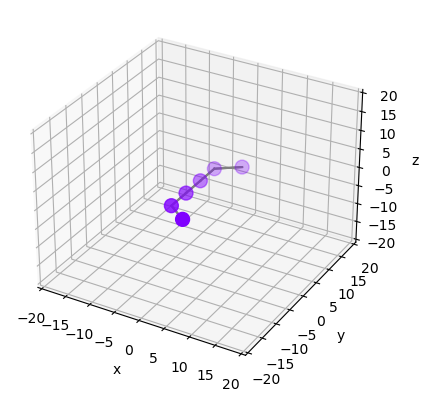

In [4]:
k = 4

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    # plot_2d(data, lim=5*k)
    plot_3d(data, lim=5*k)

In [8]:
# Set model
model_name = "gvp"#one can run every model by simply entering the model label given in the list below

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.26s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.23s ± 0.15. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.81s/it]



Done! Averaged over 10 runs: 
 - Training time: 13.78s ± 0.17. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.77s/it]



Done! Averaged over 10 runs: 
 - Training time: 17.74s ± 0.33. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.54s/it]



Done! Averaged over 10 runs: 
 - Training time: 21.50s ± 0.36. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.28s/it]


Done! Averaged over 10 runs: 
 - Training time: 25.25s ± 0.26. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [9]:
# Set model
model_name = "mpnn"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for MPNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.41s ± 0.05. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 3
Running experiment for MPNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.54s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.52s ± 0.13. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 4
Running experiment for MPNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.69s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.67s ± 0.16. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 5
Running experiment for MPNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.68s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.65s ± 0.16. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6
Running experiment for MPNNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.30s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.28s ± 0.56. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

